# Classical ML Approach: TF-IDF + Logistic Regression

## Overview

This notebook implements a classical machine learning pipeline for sentiment classification:
1. **Text Preprocessing**: Cleaning and normalization
2. **TF-IDF Vectorization**: Convert text to numerical features
3. **Logistic Regression**: Train classifier on TF-IDF features

## Why TF-IDF?

- **Interpretability**: Features correspond to actual words
- **Efficiency**: Fast training and prediction
- **Works well with limited data**: Doesn't require large datasets
- **No GPU needed**: Runs efficiently on CPU


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
# Load data
with open('../imdb_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train_text = data['X_train_text']
X_test_text = data['X_test_text']
y_train = data['y_train_classical']
y_test = data['y_test_classical']

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")
print(f"\nClass distribution (training):")
print(f"  Positive: {np.sum(y_train == 1)}")
print(f"  Negative: {np.sum(y_train == 0)}")


Training samples: 10000
Test samples: 10000

Class distribution (training):
  Positive: 5035
  Negative: 4965


## Text Preprocessing

We'll clean the text by:
- Converting to lowercase
- Removing special characters
- Removing stopwords (optional, can be controlled in TF-IDF)
- Basic normalization


In [3]:
def preprocess_text(text):
    """Basic text preprocessing."""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Preprocess texts
print("Preprocessing texts...")
X_train_processed = [preprocess_text(text) for text in X_train_text]
X_test_processed = [preprocess_text(text) for text in X_test_text]

print("Example original text:")
print(X_train_text[0][:200])
print("\nExample processed text:")
print(X_train_processed[0][:200])


Preprocessing texts...
Example original text:
? there's a major difference between releasing an original intense edge of your seat scary gore fest and doing like filmmaker eli roth and his team have done with cabin fever and simply acted like it 

Example processed text:
theres a major difference between releasing an original intense edge of your seat scary gore fest and doing like filmmaker eli roth and his team have done with cabin fever and simply acted like it the


## TF-IDF Vectorization

TF-IDF (Term Frequency-Inverse Document Frequency) converts text documents into numerical feature vectors where:
- **TF**: How frequently a word appears in a document
- **IDF**: How rare a word is across all documents

This gives higher weights to words that are distinctive to a document.


In [4]:
# Create TF-IDF vectorizer
# max_features: limit vocabulary size for efficiency
# ngram_range: use unigrams and bigrams
# min_df: ignore terms that appear in less than 2 documents
# max_df: ignore terms that appear in more than 95% of documents (likely stopwords)
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # unigrams and bigrams
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

print("Fitting TF-IDF vectorizer...")
start_time = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)
tfidf_fit_time = time.time() - start_time

X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

print(f"TF-IDF transformation complete in {tfidf_fit_time:.2f} seconds")
print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Test features shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")


Fitting TF-IDF vectorizer...
TF-IDF transformation complete in 3.56 seconds
Training features shape: (10000, 5000)
Test features shape: (10000, 5000)
Vocabulary size: 5000


## Train Logistic Regression Classifier


In [5]:
# Train logistic regression
print("Training Logistic Regression...")
start_time = time.time()
lr_classifier = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    C=1.0  # Inverse of regularization strength
)
lr_classifier.fit(X_train_tfidf, y_train)
training_time = time.time() - start_time

print(f"Training complete in {training_time:.2f} seconds")


Training Logistic Regression...
Training complete in 0.17 seconds


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


In [6]:
# Make predictions
y_pred = lr_classifier.predict(X_test_tfidf)
y_pred_proba = lr_classifier.predict_proba(X_test_tfidf)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Test Accuracy: 0.8727

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      4981
    Positive       0.87      0.88      0.87      5019

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



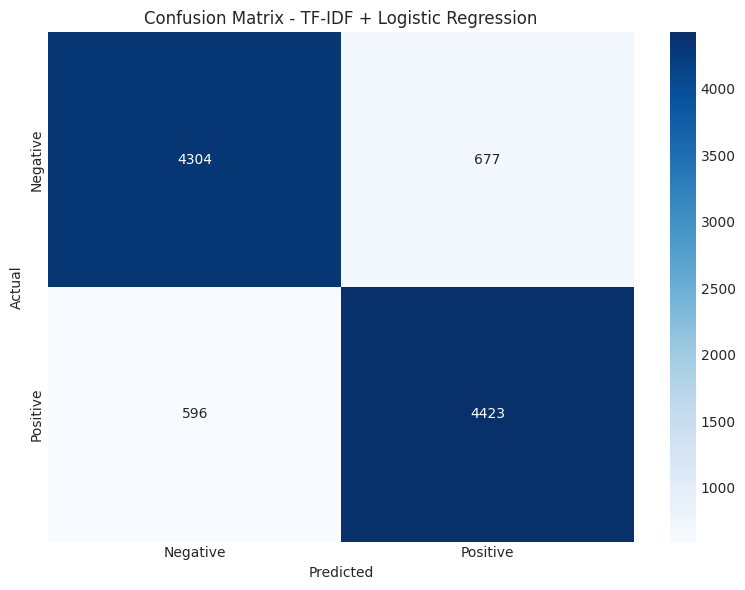

In [7]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - TF-IDF + Logistic Regression')
plt.tight_layout()
plt.show()


## Feature Importance Analysis

One advantage of TF-IDF + Logistic Regression is interpretability. We can see which words are most important for positive/negative classification.


Top 20 Features for Positive Sentiment:
  great                : 5.5405
  excellent            : 4.0550
  best                 : 3.8982
  wonderful            : 3.5185
  perfect              : 3.3854
  love                 : 3.3807
  amazing              : 2.8697
  fun                  : 2.8091
  favorite             : 2.7641
  fantastic            : 2.6242
  life                 : 2.6236
  heart                : 2.4869
  loved                : 2.4626
  beautiful            : 2.4398
  today                : 2.4090
  classic              : 2.2420
  superb               : 2.2198
  definitely           : 2.1868
  enjoyed              : 2.0856
  rare                 : 2.0216

Top 20 Features for Negative Sentiment:
  worst                : -5.8957
  bad                  : -5.6988
  awful                : -4.7810
  boring               : -4.4603
  waste                : -4.1058
  poor                 : -3.5936
  terrible             : -3.4795
  worse                : -3.3706
  unfortunately

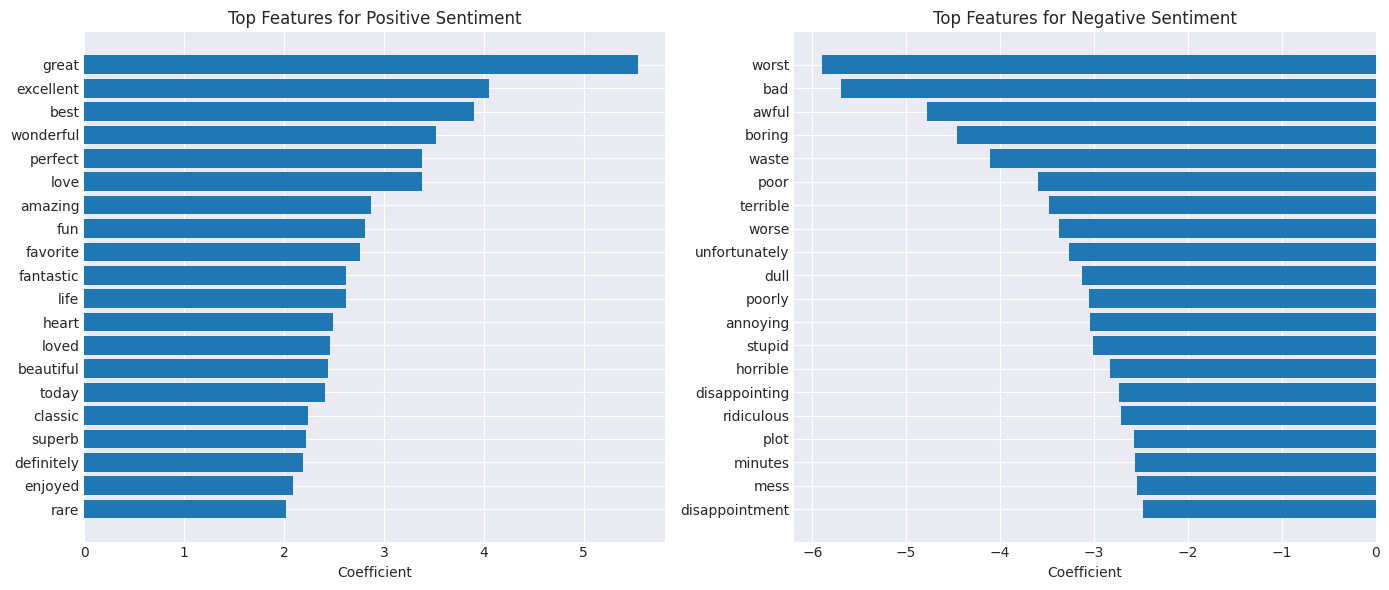

In [8]:
# Get feature names and coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_classifier.coef_[0]

# Get top positive and negative features
top_n = 20
top_positive_indices = np.argsort(coefficients)[-top_n:][::-1]
top_negative_indices = np.argsort(coefficients)[:top_n]

print("Top 20 Features for Positive Sentiment:")
for idx in top_positive_indices:
    print(f"  {feature_names[idx]:20s} : {coefficients[idx]:.4f}")

print("\nTop 20 Features for Negative Sentiment:")
for idx in top_negative_indices:
    print(f"  {feature_names[idx]:20s} : {coefficients[idx]:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

top_pos_words = [feature_names[idx] for idx in top_positive_indices]
top_pos_coefs = [coefficients[idx] for idx in top_positive_indices]

top_neg_words = [feature_names[idx] for idx in top_negative_indices]
top_neg_coefs = [coefficients[idx] for idx in top_negative_indices]

axes[0].barh(range(len(top_pos_words)), top_pos_coefs)
axes[0].set_yticks(range(len(top_pos_words)))
axes[0].set_yticklabels(top_pos_words)
axes[0].set_xlabel('Coefficient')
axes[0].set_title('Top Features for Positive Sentiment')
axes[0].invert_yaxis()

axes[1].barh(range(len(top_neg_words)), top_neg_coefs)
axes[1].set_yticks(range(len(top_neg_words)))
axes[1].set_yticklabels(top_neg_words)
axes[1].set_xlabel('Coefficient')
axes[1].set_title('Top Features for Negative Sentiment')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


## Save Results for Comparison

We'll save the results to compare with the deep learning approach.


In [9]:
# Save results
results_classical = {
    'accuracy': accuracy,
    'training_time': training_time,
    'tfidf_fit_time': tfidf_fit_time,
    'total_time': training_time + tfidf_fit_time,
    'model': lr_classifier,
    'vectorizer': tfidf_vectorizer
}

with open('../results_classical.pkl', 'wb') as f:
    pickle.dump(results_classical, f)

print("Results saved to '../results_classical.pkl'")
print(f"\nSummary:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Training Time: {training_time:.2f} seconds")
print(f"  Total Time (including TF-IDF): {results_classical['total_time']:.2f} seconds")


Results saved to '../results_classical.pkl'

Summary:
  Accuracy: 0.8727
  Training Time: 0.17 seconds
  Total Time (including TF-IDF): 3.73 seconds
